In [26]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import numpy.random as nprm

import pandas_datareader.data as web
import datetime 

from numba import njit
from scipy import stats


# Option Pricing of a synthetic asset

The Black-Scholes equation has been a revolutionary tool in finance, providing a simple model for option pricing.
In this notebook I play a little with this equation, but it is very important to take it for what it is: a simple theoretical model. Markets do not fluctuate in a Gaussian fashion with constant drift, and even if they did, *everything (publicly known) is priced in* already. 


## Modelling stock price as geometric brownian motion
Let's first define a function which returns a random trajectory using a geometric brownian motion, define by the stochastic differential equation,
$$\frac{dS}{S}= \left(r - \frac{1}{2} \sigma^2 \right)  dt + \sigma dW$$

Where $r$ is the drift, $\sigma$ the volatility, and $W$ is Wiener process. The factor $(r - \sigma^2/2)$ instead of $r$ alone appears as consequence of the Ito's lemma.


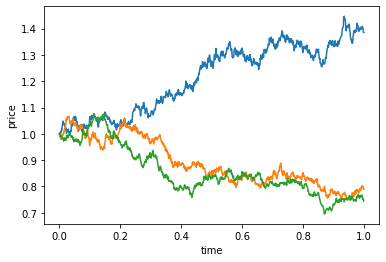

In [34]:
@njit(fastmath = True)
def price_in_time(steps:int,sigma:float,r:float, dt:float, S0:float = 1.0):
    '''
    Returns one single stochastic trajectory of a geometrical brownian motion.

    '''
    logS:np.array = np.zeros(steps)  
    a:float = (r - 0.5 * sigma * sigma ) * dt
    b:float = (sigma * np.sqrt(dt))    
    for i in range(1,steps):
        logS[i] =   logS[i-1]  +  ( a  +   b *nprm.normal(0,1)  )
    return S0 * np.exp(logS) 

# Parameters of the geometric brownian motion
initial_price = 1.0
steps = 1000
final_time = 1
dt = final_time/steps
sigma =  0.2
r =  0.1 

# Creating and ploting three trajectories as examples
for _ in range(3):
    S = price_in_time(steps,sigma,r, dt, initial_price)
    time = np.arange(steps)*dt
    plt.plot(time,S)
    
plt.xlabel('time')
plt.ylabel('price')
plt.show()


We use numba to *compile* a part of the python code, so it runs significanly faster.
We showed three trajectories as example. For more robus analysis, we will consider `runs` trajectories and compute some statistics on it. Evidently, we recover the values entered for $r$ and $\sigma$. 
The final price follows a log-normal distriution. This means that what has a standard deviation $\sigma$ is the logarithm of the final price, and not the price itself.
Mode, mean and median do not coincide. The expected gains in this case are $S_0 r = 0.05$. However, there is approximately 50\% of obtaining less than 0.3 as gains.



==== COMPARING INPUT PARAMETERS AND OUTPUT STATS ====
r=0.1 sigma=0.2 
mean final price = 1.1054204639852876  
median final price = 1.0836261472746682  
std log final price = 0.19993463600878977 



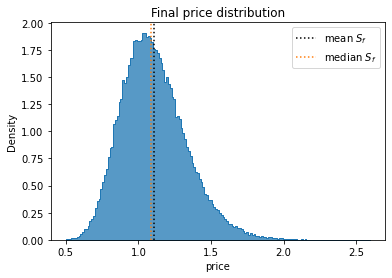

In [29]:
runs = 100000 # number of independent trajectories

final_price = np.array( [price_in_time(steps, sigma, r, dt, initial_price)[-1] for _ in range(runs)])
mean_fp = np.mean(final_price)
median_fp = np.median(final_price)
std_fp = np.std(final_price)
std_logfp = np.std( np.log(final_price) )
out_txt = '''
==== COMPARING INPUT PARAMETERS AND OUTPUT STATS ====
r={r} sigma={sigma} 
mean final price = {mean_fp}  
median final price = {median_fp}  
std log final price = {std_logfp} 
'''
print(out_txt.format(r=r, sigma=sigma, 
                     mean_fp=mean_fp, median_fp=median_fp, std_logfp=std_logfp) )

sns.histplot(final_price, stat='density', element='step')
plt.axvline(mean_fp,ls=':',color='k',label='mean $S_f$')
plt.axvline(median_fp,ls=':',color='C1',label='median $S_f$')
plt.xlabel('price')
plt.title('Final price distribution')
plt.legend()
plt.show()




## Option prices: Comparing Black-Scholes and Montecarlo
Here we will present two ways to evaluate the price of an option: Monte Carlo and using Black-Scholes.
The advantage of Black-Scholes is that it is an accurate formula for the price of an option when the price of the underlying fluctuates according to a geometric Brownian motion.
On the other hand, Monte Carlo is a method applicable to basically any model of fluctuations for the price of the underlying, at the cost of being computationally more expensive.

Let's define functions to price call and put options using Black-Scholes, and then using Montecarlo.

In [30]:
def BlackScholes_call(S, K, T, r, sigma): 
    '''
    Price of a call option following Black-Scholes
    Parameters
    ----------
    S : float
        spot price.
    K : float
        strike price.
    T : float
        time to maturity.
    r : float
    	risk-free interest rate.
    sigma : float
        volatility of the asset.

    Returns
    -------
    cprice : float
        price of the call option.

    '''
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    cprice = (S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    
    return cprice

def BlackScholes_put(S, K, t, r, sigma):
    '''
    Price of a put option following Black-Scholes
    Parameters
    ----------
    S : float
        spot price.
    K : float
        strike price.
    t : float
        time to maturity.
    r : float
    	risk-free interest rate.
    sigma : float
        volatility of the asset.

    Returns
    -------
    pprice : float
        price of the put option.

    '''
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    
    pprice = (K * np.exp(-r * t) * stats.norm.cdf(-d2, 0.0, 1.0) - S * stats.norm.cdf(-d1, 0.0, 1.0))
    
    return pprice

def Montecarlo_call(Sf,K,r,t):
    '''
    Price of a call option using montecarlo
    Parameters
    ----------
    Sf : numpy array
        array with the final price of several independent runs
    K : float
        strike price.
    r : float
    	risk-free interest rate.
    t : float
        time to maturity.

    Returns
    -------
    float
        price of the call option.

    '''    
    
    return ( (Sf[Sf >= K] - K).sum() / Sf.size ) * np.exp(-r * t)

def Montecarlo_put(Sf,K,r,t):
    '''
    Price of a put option using montecarlo
    Parameters
    ----------
    Sf : numpy array
        array with the final price of several independent runs
    K : float
        strike price.
    r : float
    	risk-free interest rate.
    t : float
        time to maturity.

    Returns
    -------
    float
        price of the put option.

    '''        
    return ( ( K - Sf[Sf <= K] ).sum() / Sf.size ) * np.exp(-r * t)

If we compare the analytical value obtained from Black-Scholes formula and a Montecarlo estimation, they coincide with all the decimals you want as you increase the number of runs

In [31]:
K = 1.2
print('Black-Scholes call price = \t',
      BlackScholes_call(initial_price, K , final_time, r,sigma))

print('Montecarlo call price = \t',
     Montecarlo_call(final_price, K, r, final_time))

Black-Scholes call price = 	 0.04708214272370065
Montecarlo call price = 	 0.04711204380830285


Montearlo is most realiable in the region where we have enough statistics. Evaluating the price around values several standard deviations beyond the median generates increasingly unreliable estimates.

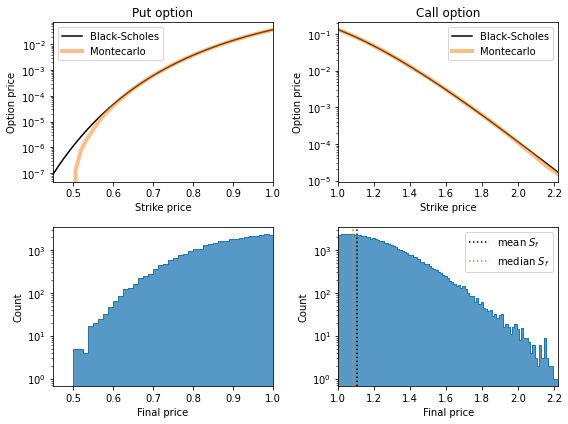

In [32]:
call_strikes = np.linspace(initial_price, initial_price * np.exp(4*sigma), 40)
bs_call = [BlackScholes_call(initial_price, K , final_time, r,sigma) for K in call_strikes ]
mc_call = [Montecarlo_call(final_price,K,r,final_time) for K in call_strikes ]

put_call_strikes = np.linspace(initial_price * np.exp(-4*sigma), initial_price, 40)
bs_put = [BlackScholes_put(initial_price, K , final_time, r,sigma) for K in put_call_strikes ]
mc_put = [Montecarlo_put(final_price,K,r,final_time) for K in put_call_strikes ]

fig, axs = plt.subplots(2,2,figsize=(8,6))
axs = axs.reshape(4)

plt.sca(axs[0])
plt.title('Put option')
plt.plot(put_call_strikes,bs_put,label='Black-Scholes',color='k')
plt.plot(put_call_strikes,mc_put,label='Montecarlo',lw=4,alpha=0.5,color='C1')
plt.yscale('log')
plt.legend()
plt.xlabel('Strike price')
plt.ylabel('Option price')
plt.xlim(put_call_strikes[0],put_call_strikes[-1])

plt.sca(axs[2])
sns.histplot(final_price, stat='count', element='step')
plt.xlabel('Final price')
plt.tight_layout()
plt.xlim(put_call_strikes[0],put_call_strikes[-1])
plt.yscale('log')

plt.sca(axs[1])
plt.title('Call option')
plt.plot(call_strikes,bs_call,label='Black-Scholes',color='k')
plt.plot(call_strikes,mc_call,label='Montecarlo',lw=4,alpha=0.5,color='C1')
plt.yscale('log')
plt.legend()
plt.xlabel('Strike price')
plt.ylabel('Option price')
plt.xlim(call_strikes[0],call_strikes[-1])

plt.sca(axs[3])
sns.histplot(final_price, stat='count', element='step')
plt.axvline(mean_fp,ls=':',color='k',label='mean $S_f$')
plt.axvline(median_fp,ls=':',color='C1',label='median $S_f$')
plt.xlabel('Final price')
plt.tight_layout()
plt.xlim(call_strikes[0],call_strikes[-1])
plt.yscale('log')
plt.legend()

plt.show()

This works very elegantly when all hypotheses are satisfied and we have full knowledge of the system parameters. However, if instead of knowing the values of $r$, $\sigma$, *etc*, we only have a single trajectory, things start to get complicated. If we instead of using multiple runs, we relied on only one, we fail at recovering the value for $\sigma$, as each run yields a different average. And it is even more unrealiable to infer the value of $r$. where the 95% of the distribution of observed $r$ can land in a huge range of values. However, usually the value of $r$ is taken as the risk-free interest in the whole market, not as the drift of the subyacent asset.

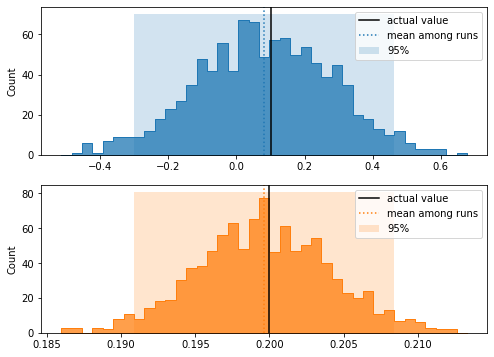

In [109]:
runs = 1000
logSt = [ np.log( price_in_time(steps, sigma, r, dt, initial_price) ) for i in range(runs) ]
list_r  = np.array( [np.mean( logS[1:] - logS[:-1] ) / dt  for logS in logSt] )
list_sigma = np.array( [ np.std( logS[1:] - logS[:-1] ) / np.sqrt(dt) for logS in logSt] )


left_r = np.percentile(list_r, 2.5)
right_r = np.percentile(list_r, 97.5)

left_sigma = np.percentile(list_sigma, 2.5)
right_sigma = np.percentile(list_sigma, 97.5)


fig, axs = plt.subplots(2,1,figsize=(8,6))

plt.sca(axs[0])
bins = np.mean(list_r) + np.linspace(-3*np.std(list_r),3*np.std(list_r),40)
sns.histplot(list_r, bins=bins, color='C0', element='step' )
plt.axvline(r, ls='-',color='k',label='actual value')
plt.axvline(np.mean(list_r),ls=':',color='C0',label='mean among runs')
ym,yM = axs[0].get_ylim()
axs[0].fill_between(bins, ym,yM,where= (bins>left_r) & (bins<right_r),
                        facecolor='C0',alpha=0.2,label='95%')
plt.legend()

plt.sca(axs[1])
bins = np.mean(list_sigma) + np.linspace(-3*np.std(list_sigma),3*np.std(list_sigma),40)
sns.histplot(list_sigma, bins=bins, color='C1', element='step' )
plt.axvline(sigma,ls='-',color='k',label='actual value')
plt.axvline(np.mean(list_sigma),ls=':',color='C1',label='mean among runs')
ym,yM = axs[1].get_ylim()
axs[1].fill_between(bins, ym,yM,where= (bins>left_sigma) & (bins<right_sigma),
                        facecolor='C1',alpha=0.2,label='95%')
plt.legend()
plt.show()

## Coming next: Real world data
I have done a small analysis and comparison of two models for option pricing, and I have made some observations on why it works poorly. My intention is to then show how it works much worse with real world data.